# Modelado de la función sinusoidal con NeuralODEs

In [27]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions

Para esto tenémos que crear una ecuación diferencial parametrizada que me permita aprender la solución que buscamos. En este caso al menos le damos lo que se espera que sea la solución sinusoidal que es de gran ayuda. Igualmente se podrían utilizar otras combinaciones de funciones trigonométricas para probar.

In [38]:
function parametric_ode_system!(du,u,p,t)
    y = u
    ω, A = p
    du[1] = dy = A*4π*cos(ω*4π*t)
  end;

Ahora seteamos el tiempo de simulación y los parámetros de la ecuación diferencial, como así la condición inicial del problema

In [44]:
tbegin = -1
tstep = 0.01
tend = 1
trange = tbegin:tstep:tend
p = rand(2)
push!(p, 0.0)
tspan = (tbegin, tend)
u0 = [p[3]];

Creamos el problema de ecuaciones diferenciales parametrizado. Además creamos lo que sería nuestra red neuronal que consiste en el resolvedor de ODEs.

In [45]:
prob = ODEProblem(parametric_ode_system!, u0, tspan, p)
function net()
    solve(prob, Tsit5(), p=p, saveat=trange)
end
sol = net()
x = vcat(sol.u...);

Generamos los datos de entrenamiento y datos de prueba de la función sinusoidal con ruido gaussiano

In [46]:
function sine_with_noise(t)
    return sin(4π*t) + rand(Normal(0,0.1))
end;

In [47]:
dataset_outs = [sine_with_noise.(trange)]
test_dataset = [sine_with_noise.(trange)];

Graficamos hora sí tanto solución de la ecuación diferencial como los datos de entrenamiento. Esto dependiendo de las condiciones iniciales aleatorias que se setearon puede estar cerca o lejos de la función sinusoidal con ruido

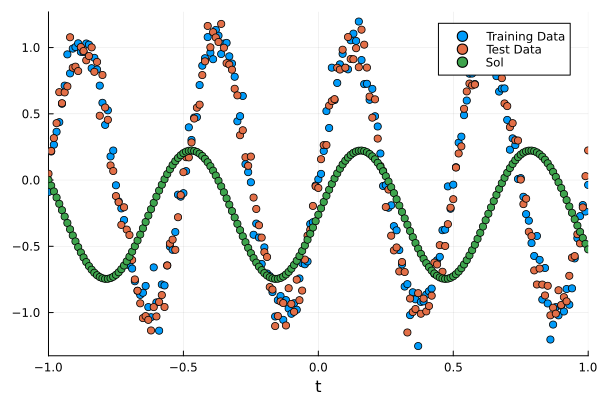

In [48]:
scatter(trange, dataset_outs, label = "Training Data")
scatter!(trange, test_dataset, label = "Test Data")
scatter!(sol, label = "Sol")

Creamos la función loss que es la diferencia entre la solución de la ecuación diferencial y los datos de entrenamiento

In [55]:
function loss_func()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, dataset_outs[1] .- pred)
  end;

In [56]:
function loss_func2()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, test_dataset[1] .- pred)
  end

loss_func2 (generic function with 1 method)

Creamos una función para ver la predicción de la red neuronal en cada época

In [57]:
function accuracy(y)
    num_correct = 0
    predictions = net()
    predictions = vcat(predictions.u...)
    for i in 1:length(predictions)
        if abs(predictions[i] - y[1][i]) < 0.2
            num_correct += 1
        end
    end
    return (num_correct/length(predictions)) * 100.0
end;

Ahora entrenamos la red durante 50 épocas con el método de optimización Adam y un learning rate de 0.1, además en cada época guardamos los datos del loss y la presición

In [59]:
epochs = 50
learning_rate = 0.1
data = Iterators.repeated((), epochs)
opt = ADAM(learning_rate)
iter = 0
losses = []
losses_test = []
accuracys = []
accuracys_test = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_func()
  println("Epoch: $iter | Loss: $actual_loss")
  push!(losses, actual_loss)
  push!(losses_test, loss_func2())
  push!(accuracys, accuracy(dataset_outs))
  push!(accuracys_test, accuracy(test_dataset))
  #plt = plot(solve(remake(prob, p=p), Tsit5()))
  #scatter!(trange, dataset_outs)
  #display(plt)
  #display(plot(solve(remake(prob,p=p),Tsit5()));
  #        scatter!(trange,dataset_outs))
end
fparams = Flux.params(p)

cb()

Flux.train!(loss_func, fparams, data, opt, cb=cb)

Epoch: 1 | Loss: 3.3731161440834425


Epoch: 2 | Loss: 171.71628791721628
Epoch: 3 | Loss: 41.99094153896203
Epoch: 4 | Loss: 37.56940053441504
Epoch: 5 | Loss: 69.72095636157584
Epoch: 6 | Loss: 40.1112708213084
Epoch: 7 | Loss: 19.401977239388735
Epoch: 8 | Loss: 27.496972160372724
Epoch: 9 | Loss: 41.88876449044502
Epoch: 10 | Loss: 48.1143998917295
Epoch: 11 | Loss: 45.33719862041919
Epoch: 12 | Loss: 36.63622890580024
Epoch: 13 | Loss: 27.349375579035527
Epoch: 14 | Loss: 23.816728718144557
Epoch: 15 | Loss: 27.668390674628085
Epoch: 16 | Loss: 31.66618124808506
Epoch: 17 | Loss: 27.46849133399984
Epoch: 18 | Loss: 16.56641381405258
Epoch: 19 | Loss: 10.54463641415215


Epoch: 20 | Loss: 14.643429254081049
Epoch: 21 | Loss: 17.649005739956685
Epoch: 22 | Loss: 10.727933317680066
Epoch: 23 | Loss: 3.4244283502511967
Epoch: 24 | Loss: 8.49984104193058
Epoch: 25 | Loss: 11.145433737365249
Epoch: 26 | Loss: 3.25964166317225
Epoch: 27 | Loss: 4.570927274121183
Epoch: 28 | Loss: 9.877160429786723
Epoch: 29 | Loss: 4.625383814780526
Epoch: 30 | Loss: 3.9002458940294207
Epoch: 31 | Loss: 8.921313076523862
Epoch: 32 | Loss: 4.3816274382520515
Epoch: 33 | Loss: 4.361872000089799


Epoch: 34 | Loss: 7.485134786019456
Epoch: 35 | Loss: 3.773544518372845
Epoch: 36 | Loss: 3.8811092265253184
Epoch: 37 | Loss: 5.818644029641191
Epoch: 38 | Loss: 2.821726563559777
Epoch: 39 | Loss: 3.20194826108432
Epoch: 40 | Loss: 4.391996230258823
Epoch: 41 | Loss: 2.4028386211808552
Epoch: 42 | Loss: 2.5334438895277116
Epoch: 43 | Loss: 3.6263322881430144
Epoch: 44 | Loss: 2.386865249513814
Epoch: 45 | Loss: 2.3341975966518516
Epoch: 46 | Loss: 3.2834332964253234
Epoch: 47 | Loss: 2.6469557832068786
Epoch: 48 | Loss: 2.306044343017134
Epoch: 49 | Loss: 3.0449747250304733
Epoch: 50 | Loss: 2.7446602245245626
Epoch: 51 | Loss: 2.276816753639175


Una vez entrenada la NeuralODE, lo que hacemos es graficar los datos de entenamiento y los de la predicción de la red neuronal. Como se puede ver la red neuronal aprendió la función sinusoidal con ruido. Para esto lo que se logró es que los parámetros se actualicen de tal forma de que la solución de la ecuación diferencial se acerque a los datos de entrenamiento. Es por esto que volvemos a resovler el problema con los nuevos parámetros actualizados $p$

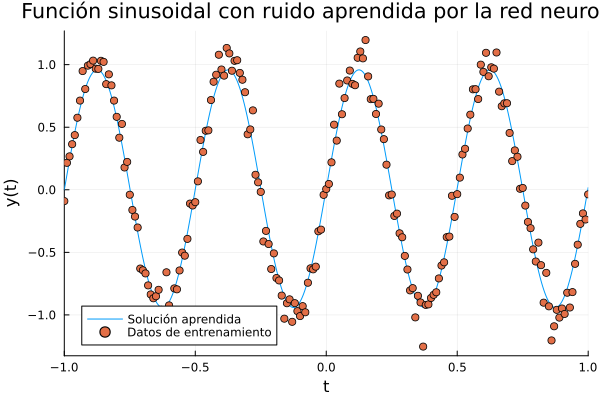

In [64]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal con ruido aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, dataset_outs, label = "Datos de entrenamiento")

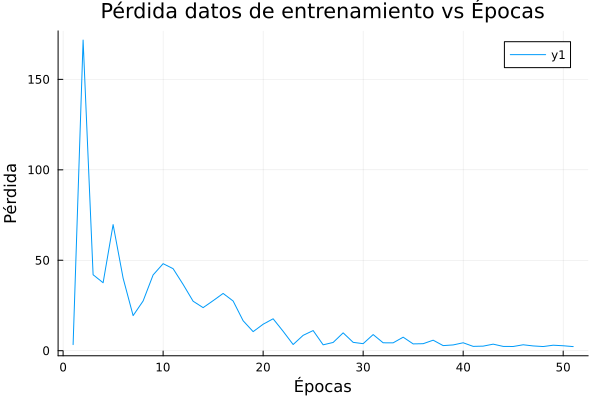

In [69]:
plot(losses, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de enetrenamiento: 94.5273631840796


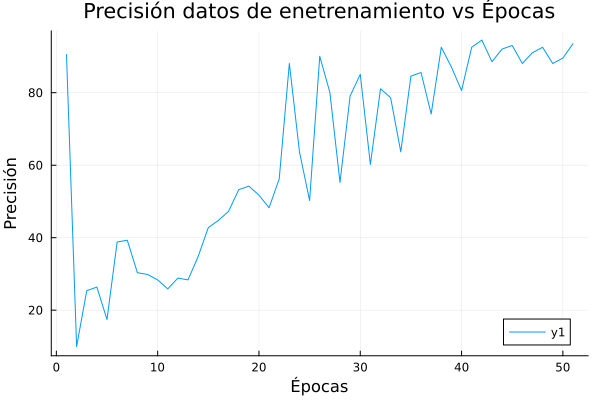

In [70]:
println("Maxima precisión en datos de enetrenamiento: ", maximum(accuracys))
plot(accuracys, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de enetrenamiento vs Épocas")

# Veamos con los datos de prueba

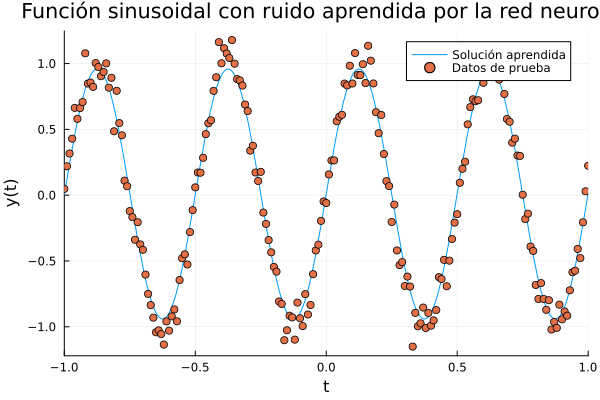

In [72]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal con ruido aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, test_dataset, label = "Datos de prueba")

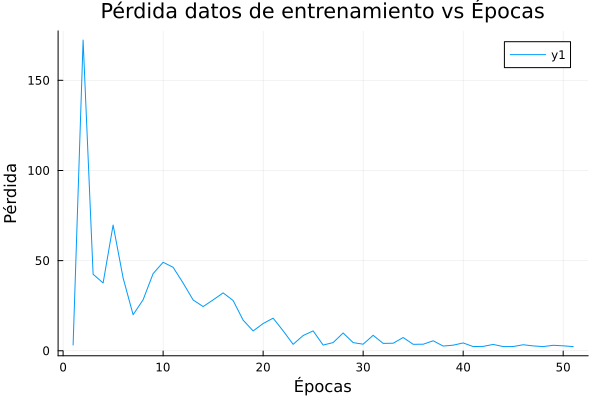

In [73]:
plot(losses_test, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de enetrenamiento: 94.02985074626866


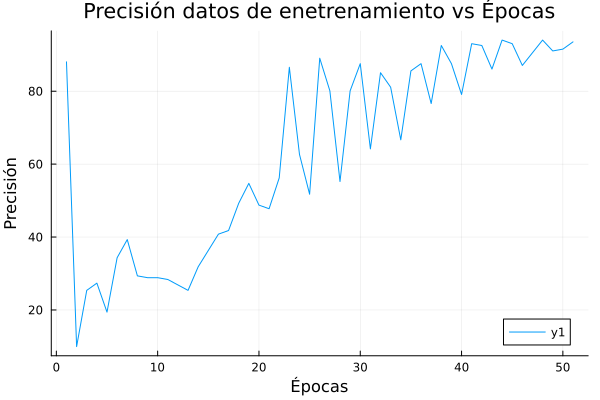

In [74]:
println("Maxima precisión en datos de enetrenamiento: ", maximum(accuracys_test))
plot(accuracys_test, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de enetrenamiento vs Épocas")

Como vemos esta NeuralODE comparada con los métodos anteriores mejora hasta un 1% la presición en los datos de entrenamiento comparada con la red de varias capas que se creó con la red neuronal Feedfoward. Sin embargo esto depende mucho de las condiciones iniciales aleatorias que se le de a la ecuación diferencial.